In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import _preprocessing
import importlib
importlib.reload(_preprocessing)
prices = pd.read_csv('../cryptoCompareData/btc_prices.csv')[['close','time']]
prices = _preprocessing.CryptoCompareReader('btc', '../splits/train', drop_na_subset=['close'], add_time_columns=True,
                                                  drop_last=True).read()

prices['close_pct_changes'] = prices['close'].pct_change()*100

two_classes_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=5,classifier_borders=(0.0,),result_column_name='y_classes_2_target',window_size=10)

three_classes_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close'
                                                                    ,regression_for_days_ahead=5
                                                                    ,classifier_borders=(-0.20,0.20)
                                                                    ,result_column_name='y_classes_3_target',window_size=10)

prices = two_classes_gen.fit_transform(prices)
prices = three_classes_gen.fit_transform(prices)
prices = prices.fillna(0)
prices.head(20)

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


,Unnamed: 0_x,time,high,low,open,close,BTCTradedToUSD,USDTradedToBTC,Unnamed: 0_y,zero_balance_addresses_all_time,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,dayOfTheWeek,monthOfTheYear,close_pct_changes,y_classes_2_target,y_classes_2_feature,y_classes_3_target,y_classes_3_feature
0,0.0,2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,560,34727,...,0.0,0.0,0.0,5,7,0.000000,0,0.000000,0,0.000000
1,1.0,2010-07-18,0.08585,0.05941,0.04951,0.08584,75.01,5.0920,561,35257,...,0.0,0.0,0.0,6,7,73.379115,0,0.000000,0,0.000000
2,2.0,2010-07-19,0.09307,0.07723,0.08584,0.08080,574.00,49.6600,562,35744,...,0.0,0.0,0.0,0,7,-5.871389,0,0.000000,0,0.000000
3,3.0,2010-07-20,0.08181,0.07426,0.08080,0.07474,262.00,20.5900,563,36257,...,0.0,0.0,0.0,1,7,-7.500000,0,0.000000,0,0.000000
4,4.0,2010-07-21,0.07921,0.06634,0.07474,0.07921,575.00,42.2600,564,36679,...,0.0,0.0,0.0,2,7,5.980733,0,0.766558,0,0.766558
5,5.0,2010-07-22,0.08181,0.05050,0.07921,0.05050,2160.00,129.7800,565,36914,...,0.0,0.0,0.0,3,7,-36.245424,0,-0.507576,0,-0.507576
6,6.0,2010-07-23,0.06767,0.05050,0.05050,0.06262,2402.50,141.0700,566,37184,...,0.0,0.0,0.0,4,7,24.000000,0,-0.502379,0,-0.502379
7,7.0,2010-07-24,0.06161,0.05049,0.06262,0.05454,496.32,26.7300,567,37807,...,0.0,0.0,0.0,5,7,-12.903226,0,-0.482520,0,-0.482520
8,8.0,2010-07-25,0.05941,0.05050,0.05454,0.05050,1551.48,85.0600,568,39571,...,0.0,0.0,0.0,6,7,-7.407407,0,-0.772818,0,-0.772818
9,9.0,2010-07-26,0.05600,0.05000,0.05050,0.05600,877.00,46.9100,569,40379,...,0.0,0.0,0.0,0,7,10.891089,1,0.315116,2,0.315116


## binary regression targets (will be tending upwards or downwards)

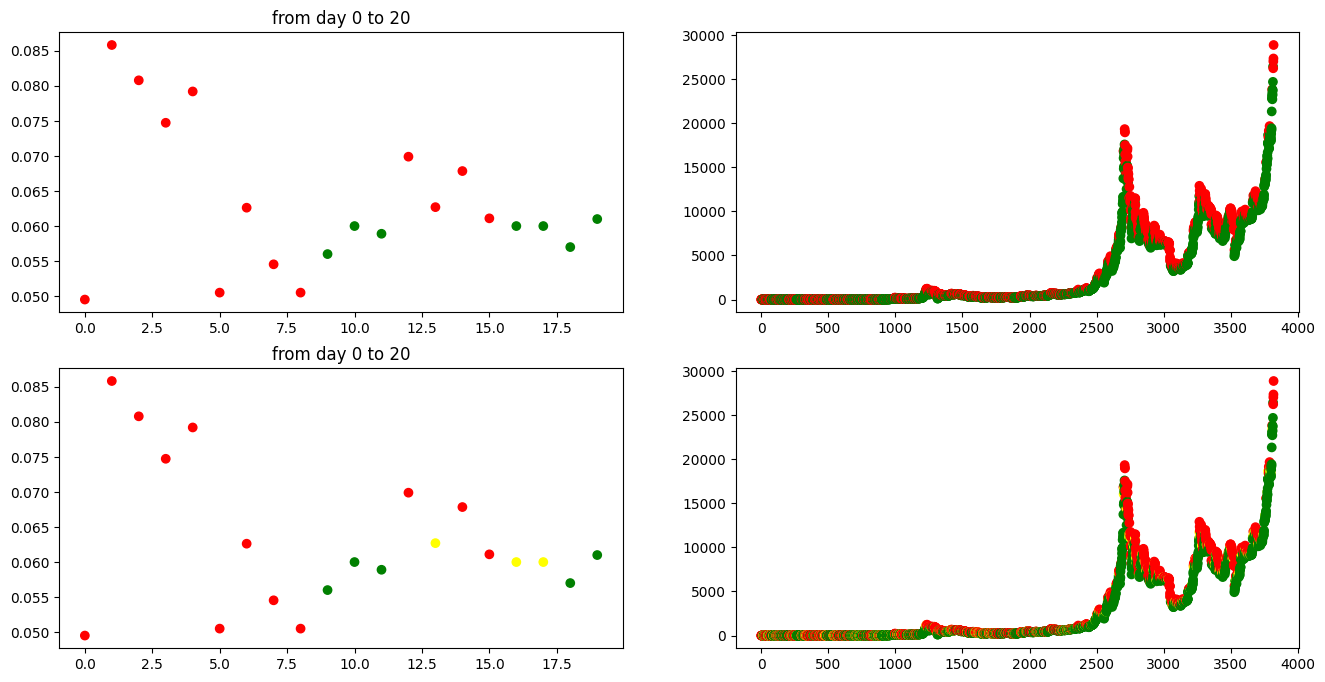

In [2]:
import matplotlib.pyplot as plt
import matplotlib

fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,8))

colors = ['red','yellow','green']
x = prices.index.tolist()
y = prices.close.values
label_2 = prices.y_classes_2_target.values
show_from = 0
show_to = 20#len(x)
axes[0][0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_2[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[0][0].set_title(f'from day {show_from} to {show_to}')
axes[0][1].scatter(x, y, c=label_2, cmap=matplotlib.colors.ListedColormap(colors))

label_3 = prices.y_classes_3_target.values
axes[1][0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[1][0].set_title(f'from day {show_from} to {show_to}')
axes[1][1].scatter(x, y, c=label_3, cmap=matplotlib.colors.ListedColormap(colors))


## normal regression targets (label is the slope of the regression)

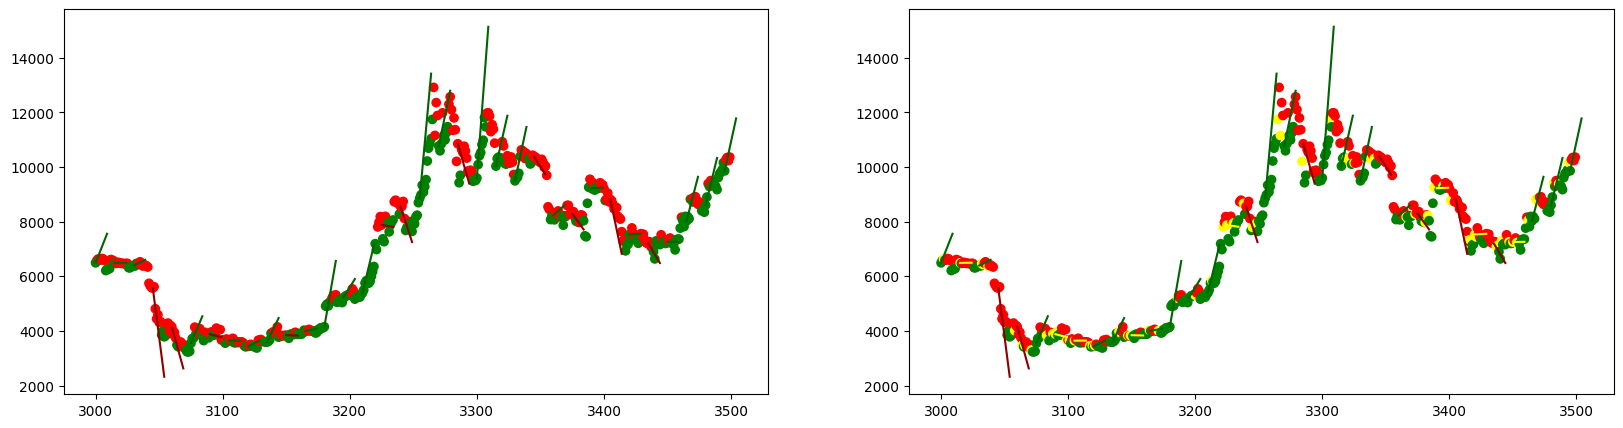

In [3]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
importlib.reload(_preprocessing)

regression_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=5,result_column_name='y_regression_target',window_size=10)

prices = regression_gen.fit_transform(prices)

fig,axes = plt.subplots(ncols=2, figsize=(20,5))

colors = ['red','yellow','green']

x = prices.index.tolist()
y = prices.close.values
label_2 = prices.y_classes_2_target.values
label_3 = prices.y_classes_3_target.values
show_from = 3000
show_to = 3500
axes[0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_2[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[1].scatter(x[show_from:show_to], y[show_from:show_to], c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))

line_at_every = 15

line_starts_values = prices.close.values[show_from::line_at_every]
line_slopes_values = prices.y_regression_target.values[show_from::line_at_every]

lines = []
line_length = 10

for line_start_idx in np.arange(show_from,show_to,15):

    x_values = np.arange(line_start_idx,line_start_idx+line_length,1)

    segment = prices.close.iloc[line_start_idx:line_start_idx+line_length]
    slope = prices.y_regression_target.iloc[line_start_idx] * np.std(segment)
    y_values = np.array([ prices.close.iloc[line_start_idx] + slope * step
                          for step in range(line_length)])

    color_2 = 'darkred' if prices.y_regression_target.iloc[line_start_idx] < 0 else 'darkgreen'
    axes[0].plot(x_values, y_values, c = color_2)

    color_3 = 'darkred' if prices.y_regression_target.iloc[line_start_idx] < -0.2 \
        else 'darkgreen' if prices.y_regression_target.iloc[line_start_idx] > 0.2 \
        else 'yellow'
    axes[1].plot(x_values, y_values, c = color_3)

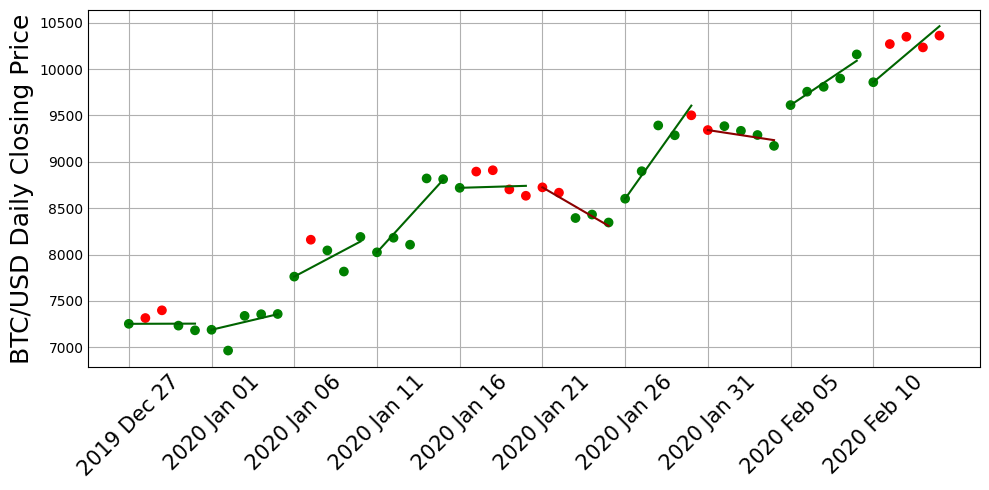

In [14]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
importlib.reload(_preprocessing)
import matplotlib
regression_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=5,result_column_name='y_regression_target',window_size=10)

prices = regression_gen.fit_transform(prices)

fig,ax = plt.subplots(ncols=1, figsize=(10,5))

colors = ['red','green']

x = prices.index.tolist()
y = prices.close.values
label_2 = prices.y_classes_2_target.values
label_3 = prices.y_classes_3_target.values
show_from = 3450
show_to = 3500

# prices.iloc[show_from:show_to].plot.scatter(x='time',y='close',rot=90, c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors),ax = ax)

ax.scatter(x[show_from:show_to], y[show_from:show_to], c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))

line_at_every = 5

line_starts_values = prices.close.values[show_from::line_at_every]
line_slopes_values = prices.y_regression_target.values[show_from::line_at_every]

lines = []
line_length = 5
ticks = []
for line_start_idx in np.arange(show_from,show_to,line_at_every):

    x_values = np.arange(line_start_idx,line_start_idx+line_length,1)
    ticks.append(x_values[0])
    segment = prices.close.iloc[line_start_idx:line_start_idx+line_length]
    slope = prices.y_regression_target.iloc[line_start_idx] * np.std(segment)
    y_values = np.array([ prices.close.iloc[line_start_idx] + slope * step
                          for step in range(line_length)])


    color_2 = 'darkred' if prices.y_regression_target.iloc[line_start_idx] < 0 \
        else 'darkgreen'
    ax.plot(x_values, y_values, c = color_2)
    ax.set_ylabel('BTC/USD Daily Closing Price',fontsize=18)
import seaborn as sns
# ax.set_xticks(ticks=list(range(len(ticks))),labels=prices['time'].iloc[ticks].reset_index(drop=True).values)
# ax.set_xticklabels(prices['time'].iloc[ticks])
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

plt.xticks(ticks, prices['time'].dt.strftime('%Y %b %d').iloc[ticks].reset_index(drop=True).values, rotation=45,fontsize=15)
plt.tight_layout()
plt.style.use("_mpl-gallery")
plt.savefig('../documents/figures/targets.png')

In [21]:
prices.columns

Index(['time', 'high', 'low', 'open', 'close', 'BTCTradedToUSD',
       'USDTradedToBTC', 'zero_balance_addresses_all_time',
       'unique_addresses_all_time', 'new_addresses', 'active_addresses',
       'transaction_count', 'transaction_count_all_time',
       'large_transaction_count', 'average_transaction_value', 'block_height',
       'hashrate', 'difficulty', 'block_time', 'block_size', 'current_supply',
       'comments', 'posts', 'followers', 'fb_likes', 'fb_talking_about',
       'twitter_followers', 'twitter_following', 'twitter_lists',
       'twitter_favourites', 'twitter_statuses', 'reddit_subscribers',
       'reddit_active_users', 'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day', 'dayOfTheWeek',
       'monthOfTheYear', 'close_pct_changes', 'y_classes_2_target',
       'y_classes_2_feature', 'y_classes_3_target', 'y_classes_3_feature',
       'y_regression_target', 'y_regression_feature'],
      dtype='object')

#### Distributions

TypeError: boolean value of NA is ambiguous

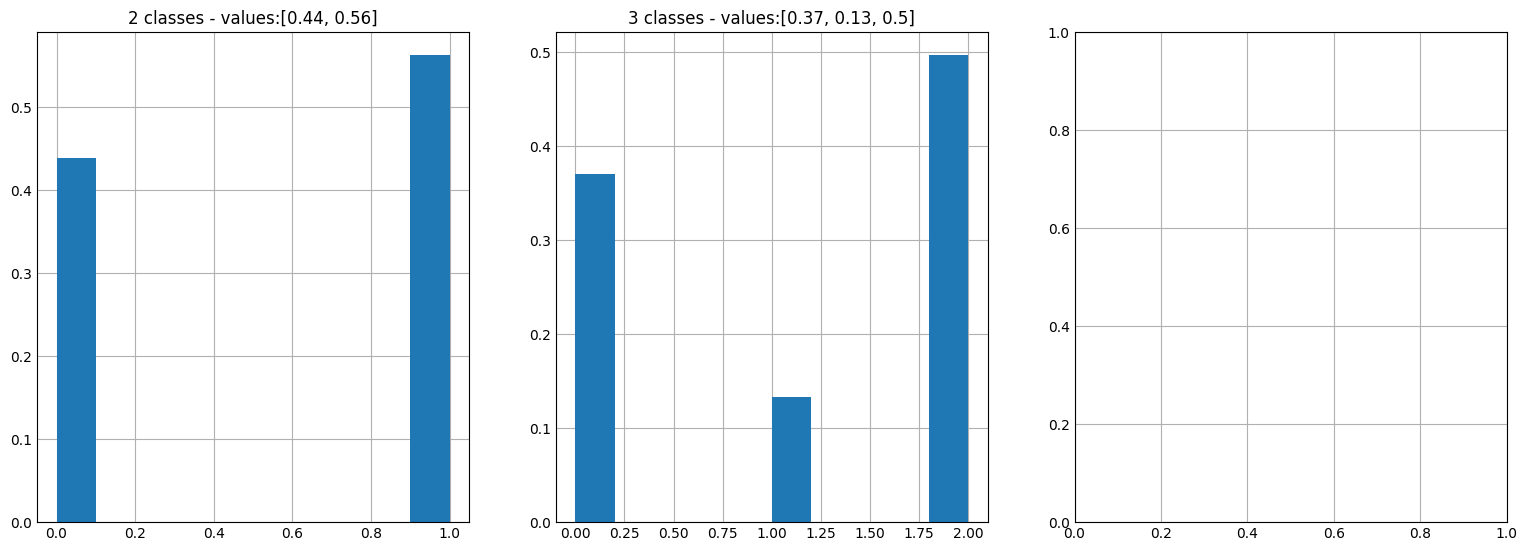

In [22]:
from matplotlib.ticker import PercentFormatter
fig,axes=plt.subplots(ncols=3,figsize=(15,5))

counts, edges, bars = axes[0].hist(prices.y_classes_2_target, weights=np.ones(len(prices)) / len(prices))
values = []
for bar in bars:
    if bar.get_height() != 0:
        values.append(round(bar.get_height(),2))
axes[0].set_title('2 classes - values:' + str(values))

counts, edges, bars = axes[1].hist(prices.y_classes_3_target, weights=np.ones(len(prices)) / len(prices))
values = []
for bar in bars:
    if bar.get_height() != 0:
        values.append(round(bar.get_height(),2))
axes[1].set_title('3 classes - values:' + str(values))

axes[2].hist(prices.y_regression_target)
axes[2].set_title('slope histogram from regression label');

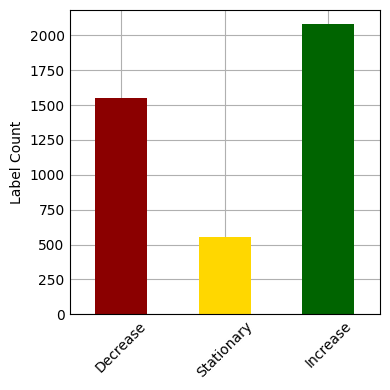

In [54]:
ax = prices.y_classes_3_target.value_counts().sort_index().plot.bar(rot=45,figsize=(4,4),color=['darkred', 'gold', 'darkgreen'])
ax.set_xticklabels(['Decrease','Stationary','Increase'])
ax.set_ylabel('Label Count')
plt.tight_layout()
plt.savefig('../documents/figures/distribution.png')

In [39]:
prices.y_classes_3_target.value_counts()

2    2078
0    1551
1     556
Name: y_classes_3_target, dtype: int64

### last value and random predictor

In [134]:
prices.head(3)

,close,close_pct_changes,debug,y_classes_2,y_classes_3,y_regression
0,0.04951,NaN,NaN,1.0,1.0,0.123990
1,0.08584,73.379115,NaN,0.0,0.0,-0.333851
2,0.08080,-5.871389,NaN,0.0,0.0,-0.331022


In [137]:
#for two classes
from models.baselines import LastValuePredictor
reshaped =np.reshape(prices.values,(len(prices),-1,prices.shape[-1]))
predictor_last_value_2_classes = LastValuePredictor(predict_feature_idx=3)
y_preds_lv_2_classes = predictor_last_value_2_classes.predict(reshaped).reshape(-1)
predictables_lv = prices.iloc[1:]
success = len(predictables_lv[predictables_lv.y_classes_2 == y_preds_lv_2_classes[:-1]])
success / len(predictables_lv)

0.8484848484848485

In [138]:
#for 3 classes
from models.baselines import LastValuePredictor
reshaped =np.reshape(prices.values,(len(prices),-1,prices.shape[-1]))
predictor_last_value_3_classes = LastValuePredictor(predict_feature_idx=4)
y_preds_lv_3_classes = predictor_last_value_3_classes.predict(reshaped).reshape(-1)
predictables_lv = prices.iloc[1:]
success = len(predictables_lv[predictables_lv.y_classes_3 == y_preds_lv_3_classes[:-1]])
success / len(predictables_lv)

0.7245386192754614

In [144]:
#2 classes random with matching distribution
import models
import importlib
importlib.reload(models.baselines)
prices_notna = prices.iloc[1:-10]
reshaped_notna=np.reshape(prices_notna.values,(len(prices_notna),-1,prices_notna.shape[-1]))
random_predictor = models.baselines.RandomBinaryPredictor(predict_feature_idx=3,match_distribution=True)
y_preds_binary = random_predictor.predict(reshaped_notna)
predictables_binary = prices_notna
success_binary = len(predictables_binary[predictables_binary.y_classes_2 ==y_preds_binary])
success_binary / len(predictables_binary)

0.5044530714775063